In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from MotionDataset import MotionData
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("CPU")

cuda


In [3]:
class MotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.0):
        super(MotionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
train_labels = "./data/train.csv"
val_labels = "./data/val.csv"
val_dir = train_dir = "./data/"

train_dataset = MotionData(train_labels, train_dir)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = MotionData(val_labels, val_dir)
val_loader = DataLoader(val_dataset, batch_size=8)

In [5]:
# model parameters
input_size = 6
# classifying up:0, down:1, left:2, right:3
num_classes = 4
num_epochs = 50

model = MotionLSTM(input_size, 100, 5, num_classes, dropout=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adagrad(model.parameters(), lr=1e-3)

Epoch 1, train loss: 1.396, train acc: 25.373%, val loss: 1.337, val acc: 23.529%
Epoch 2, train loss: 1.388, train acc: 16.418%, val loss: 1.349, val acc: 23.529%
Epoch 3, train loss: 1.381, train acc: 28.358%, val loss: 1.339, val acc: 23.529%
Epoch 4, train loss: 1.375, train acc: 29.851%, val loss: 1.345, val acc: 5.882%
Epoch 5, train loss: 1.379, train acc: 37.313%, val loss: 1.349, val acc: 5.882%
Epoch 6, train loss: 1.368, train acc: 29.851%, val loss: 1.373, val acc: 5.882%
Epoch 7, train loss: 1.259, train acc: 35.821%, val loss: 1.299, val acc: 64.706%
Epoch 8, train loss: 1.154, train acc: 50.746%, val loss: 2.606, val acc: 41.176%
Epoch 9, train loss: 1.153, train acc: 55.224%, val loss: 1.26, val acc: 47.059%
Epoch 10, train loss: 1.065, train acc: 53.731%, val loss: 1.235, val acc: 47.059%
Epoch 11, train loss: 0.9984, train acc: 50.746%, val loss: 1.24, val acc: 47.059%
Epoch 12, train loss: 1.082, train acc: 53.731%, val loss: 1.239, val acc: 52.941%
Epoch 13, train l

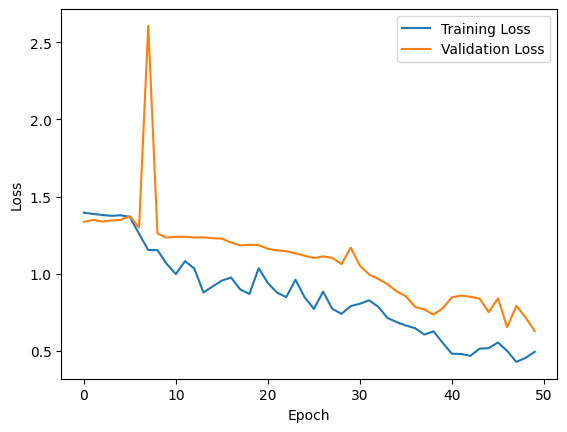

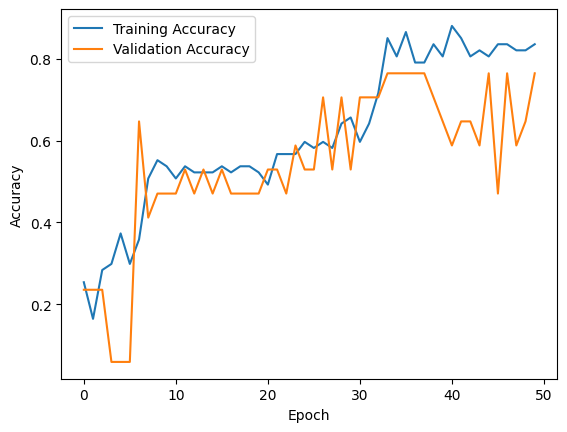

In [6]:
losses = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []
for x in range(num_epochs):
    model.train()
    running_loss = 0
    train_correct = train_total = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        yhat = model(X)
        _, pred = torch.max(nn.functional.softmax(yhat.data, dim=1), 1)
        train_total += y.size(0)
        loss = criterion(yhat, y)
        running_loss += loss.item()
        train_correct += (pred == y).sum().item()
        optim.zero_grad()
        loss.backward()
        optim.step()
    losses.append(running_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_correct = val_total = 0
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            _, pred = torch.max(nn.functional.softmax(yhat.data, dim=1), 1)
            val_total += y.size(0)
            val_loss = criterion(yhat, y)
            val_correct += (pred == y).sum().item()
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss.item())
    print(f"Epoch {x+1}, train loss: {train_loss:.4}, train acc: {train_acc:.3%}, val loss: {val_loss.item():.4}, val acc: {val_acc:.3%}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0, 1.5))
plt.legend()
plt.show()

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()